In [73]:
# Set dates of baseline and follow-up periods
d4 = '2019-03-01' # month after end of follow-up period
d3 = '2018-09-01' # follow-up start
d2 = '2018-03-01' # month after end of baseline period
d1 = '2017-09-01' # baseline start


# Import dataset from BigQuery
import pandas as pd
import numpy as np
from ebmdatalab import bq

q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_cephalosporins
WHERE EXTRACT (YEAR from month)  >= 2017
'''
df1 = bq.cached_read(q, csv_path='data/ktt9_cephalosporins_data.csv')
df1["month"] = pd.to_datetime(df1.month)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287140 entries, 0 to 287139
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   numerator         287140 non-null  int64         
 1   denominator       287140 non-null  int64         
 2   practice_id       287140 non-null  object        
 3   pcn_id            236460 non-null  object        
 4   pct_id            287140 non-null  object        
 5   stp_id            285740 non-null  object        
 6   regional_team_id  285740 non-null  object        
 7   month             287140 non-null  datetime64[ns]
 8   calc_value        251171 non-null  float64       
 9   percentile        251171 non-null  float64       
 10  month_no          287140 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 24.1+ MB


### Restrict data to baseline and follow-up periods

In [74]:
import datetime

conditions = [
    (df1['month']  >= d4), # after follow-up period
    (df1['month']  >= d3), # follow-up
    (df1['month']  >= d2), # mid
    (df1['month']  >= d1), # baseline
    (df1['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
df1['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
df2 = df1[["practice_id","period", "month", "numerator","denominator"]]
df2 = df2.set_index(["practice_id","period", "month"])
df2.head(10)

numerator  denominator
practice_id period    month                             
A81001      before    2017-06-01         13          230
                      2017-04-01          9          199
                      2017-08-01          7          158
            after     2019-08-01         12          173
                      2019-11-01          8          223
                      2019-09-01         12          175
                      2019-04-01         21          206
            follow-up 2018-09-01          8          200
            after     2019-07-01         15          207
            mid       2018-05-01          6          206

### Aggregate and rearrange data

In [75]:

dfm = df2.reset_index()
dfm = dfm.loc[(dfm.period=="baseline") | (dfm.period=="follow-up")]

### sum numerator and denominators for each practice for each period
agg_6m = dfm.groupby(["practice_id","period"]).sum()

### calculate aggregated measure values
agg_6m["calc_value"] = agg_6m.numerator / agg_6m.denominator

# unstack years
dfx = agg_6m.reset_index()
dfx = dfx[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dfx = dfx.unstack(1)

# rename columns appropriately
dfx.columns = dfx.columns.droplevel()
dfx.columns.values[0] = 'Baseline Measure'
dfx.columns.values[1] = 'Follow-up Measure'
dfx.columns.values[2] = 'Baseline Items'
dfx.columns.values[3] = 'Follow-up Items'
dfx.columns.values[4] = 'Baseline Denominator'
dfx.columns.values[5] = 'Follow-up Denominator'

dfx.head()

period,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
practice_id,,,,,,
A81001,0.046563,0.047184,63,62,1353,1314
A81002,0.085483,0.094128,580,553,6785,5875
A81003,NaN,NaN,0,0,0,0
A81004,0.081362,0.068750,258,220,3171,3200
A81005,0.110249,0.112473,270,257,2449,2285


### import **allocated** practices and merge with data

In [76]:

prac = pd.read_csv('data/practice_allocations.csv', usecols=["practice_id","ccg_id","allocation","group_ab"])
dfx2 = dfx.reset_index()

dfx2 = prac.merge(dfx2, how='left', on='practice_id')

dfx2.head()

,practice_id,ccg_id,allocation,group_ab,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
0,A83060,00D,I,A,0.110106,0.084349,146,90,1326,1067
1,A83050,00J,I,A,0.109578,0.112531,532,493,4855,4381
2,A83637,00J,con,con,0.106878,0.078813,101,77,945,977
3,A81040,00K,con,con,0.106930,0.131306,341,367,3189,2795
4,A84007,00L,I,A,0.107757,0.104662,382,330,3545,3153


### Count practices with no follow-up data

In [77]:
# Where there were no antibiotic items prescribed during follow-up period, follow-up measure is null
# .loc[pd.isnull(dfx2["Follow-up Measure"])]
null_count = dfx2.groupby("group_ab")[["Baseline Measure","Follow-up Measure"]].count()
null_count["No Follow-up"] = null_count['Baseline Measure'] - null_count['Follow-up Measure']
null_count#.sum(axis=1)

,Baseline Measure,Follow-up Measure,No Follow-up
group_ab,,,
A,356,354,2
B,347,342,5
con,698,689,9


# Plot charts

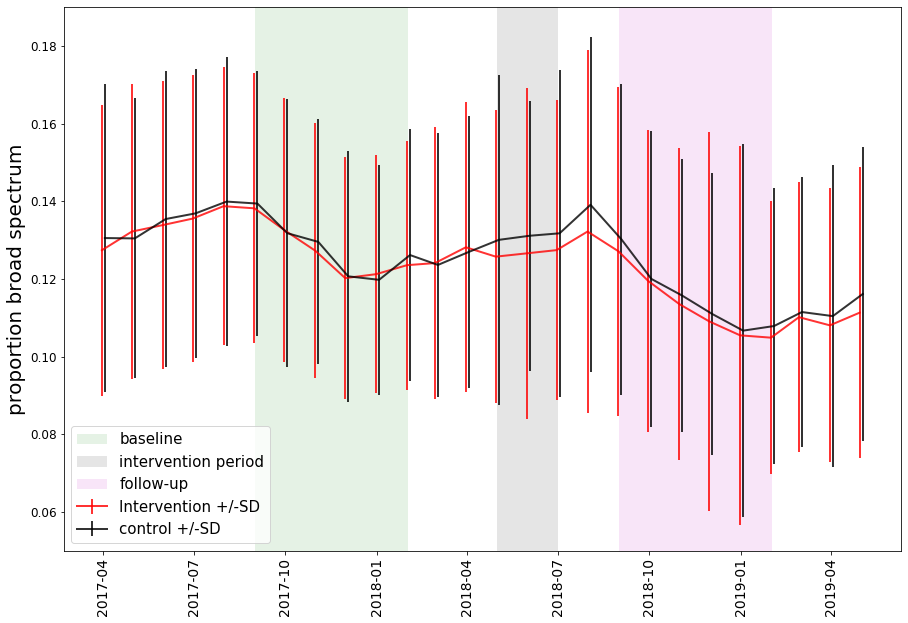

In [78]:
import matplotlib.pyplot as plt
import datetime as dt

# merge MONTHLY data with practice allocations 
plot_data = df1.loc[(df1.month_no>-14) & (df1.month_no<22)]
    
    
def plot_timetrends(df=plot_data, ymin=0.05, ymax=0.19, legend_loc="lower left", ylabel="proportion broad spectrum"): 
    # remove rows where measure value is null
    dfp = df.loc[~(pd.isnull(df.calc_value))].copy()
    dfp = prac.merge(dfp, how='left', on='practice_id')
    dfp = dfp[['practice_id','month','allocation','group_ab','calc_value']]
    
    fig = plt.subplots(figsize=(15,10))

    dfp2 = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','allocation']).mean().unstack()
    dfp2.columns = dfp2.columns.droplevel()
    dfp2.reset_index(inplace=True)

    yerror = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','allocation']).std().unstack()
    yerror.columns = yerror.columns.droplevel()
    yerror.reset_index(inplace=True)

    plt.errorbar(dfp2["month"] + pd.Timedelta(days=-1), dfp2["I"], color='r',alpha=0.8, linewidth=2, yerr=yerror["I"],label="Intervention +/-SD")
    plt.errorbar(dfp2["month"] + pd.Timedelta(days=2), dfp2["con"], color='k', alpha=0.8, linewidth=2, yerr=yerror["con"],label="control +/-SD")


    # Add vertical lines for significant time points
    xposition = ['2017-09-01', '2018-02-01','2018-09-01','2019-02-01','2018-05-01','2018-07-01']
    plt.axvspan(pd.to_datetime(xposition[0]), pd.to_datetime(xposition[1]), facecolor='g', alpha=0.1, label="baseline")
    plt.axvspan(pd.to_datetime(xposition[4]), pd.to_datetime(xposition[5]), facecolor='k', alpha=0.1, label="intervention period")
    plt.axvspan(pd.to_datetime(xposition[2]), pd.to_datetime(xposition[3]), facecolor='m', alpha=0.1, label="follow-up")


    plt.legend(loc=legend_loc, fontsize=15)

    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(rotation=90, size=14)
    plt.yticks(size=12)

    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,ymin, ymax))

    plt.show()

    
plot_timetrends()


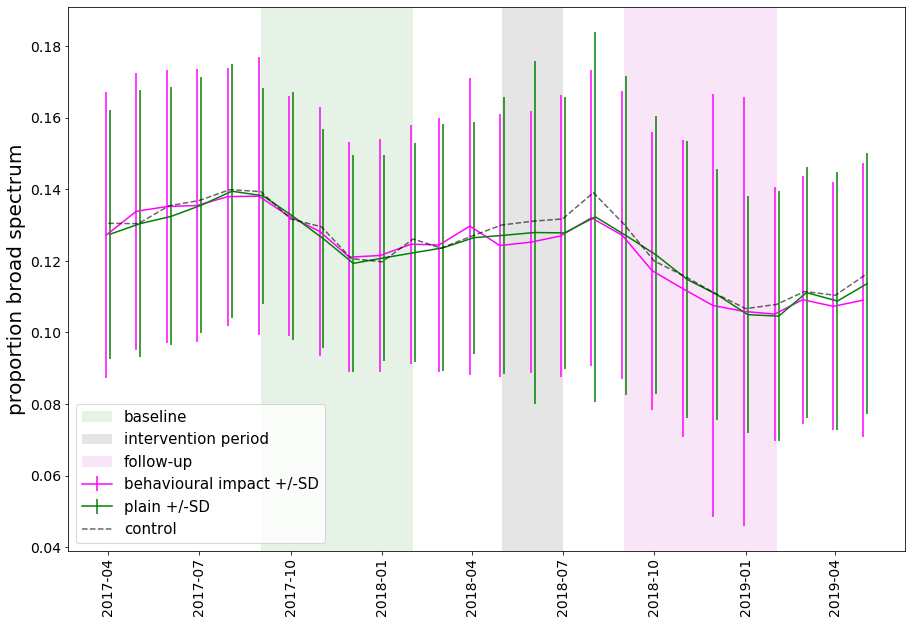

In [79]:
fig = plt.subplots(figsize=(15,10))

dfp = df1.loc[(df1.month_no>-14) & (df1.month_no<22)]
dfp = dfp.loc[~(pd.isnull(dfp.calc_value))]
dfp = prac.merge(dfp, how='left', on='practice_id')
dfp = dfp[['practice_id','month','allocation','group_ab','calc_value']]

dfp3 = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','group_ab']).mean().unstack()
dfp3.columns = dfp3.columns.droplevel()
dfp3.reset_index(inplace=True)

yerror = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','group_ab']).std().unstack()
yerror.columns = yerror.columns.droplevel()
yerror.reset_index(inplace=True)

plt.errorbar(dfp3["month"] + pd.Timedelta(days=-2), dfp3["A"], yerr=yerror["A"],label="behavioural impact +/-SD", color="magenta")
plt.errorbar(dfp3["month"] + pd.Timedelta(days=2), dfp3["B"], yerr=yerror["B"],label="plain +/-SD", color="g")
plt.errorbar(dfp3["month"], dfp3["con"],label="control", linestyle="--", alpha=0.6, color="k")

# Add vertical lines for significant time points
xposition = ['2017-09-01', '2018-02-01','2018-09-01','2019-02-01','2018-05-01','2018-07-01']
plt.axvspan(pd.to_datetime(xposition[0]), pd.to_datetime(xposition[1]), facecolor='g', alpha=0.1, label="baseline")
plt.axvspan(pd.to_datetime(xposition[4]), pd.to_datetime(xposition[5]), facecolor='k', alpha=0.1, label="intervention period")
plt.axvspan(pd.to_datetime(xposition[2]), pd.to_datetime(xposition[3]), facecolor='m', alpha=0.1, label="follow-up")


plt.legend(loc='lower left', fontsize=15)

plt.ylabel("proportion broad spectrum", fontsize=20)
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)

plt.show()

# Primary Outcome

In [80]:
# exclude practices with no follow-up data
data = dfx2.loc[pd.notnull(dfx2["Follow-up Measure"])].copy().reset_index()
# create a new Series called "intervention" to convert intervention/control to numerichange["Percentage Change"] = change['Change in Items']/change['Follow-up Items']cal values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

summary = data.groupby("intervention")[["Baseline Items", "Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(4)

,Baseline Items,Baseline Measure,Follow-up Measure,change
0,28004.21,12.71,11.59,-1.12
1,29675.43,12.67,11.25,-1.42
2,1671.22,-0.04,-0.34,-0.30


In [81]:

# Difference in the proportion of antibiotics prescribed which were broad-spectrum, 
#between intervention and control groups, assessed by applying a multivariable linear regression model.

import statsmodels.formula.api as smf

# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

formula = 'data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention'

lm = smf.ols(formula=formula, data=data).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.140
Model:                                   OLS   Adj. R-squared:                  0.138
Method:                        Least Squares   F-statistic:                     112.1
Date:                       Tue, 05 May 2020   Prob (F-statistic):           7.57e-46
Time:                               13:36:11   Log-Likelihood:                 2647.0
No. Observations:                       1385   AIC:                            -5288.
Df Residuals:                           1382   BIC:                            -5272.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0348      0.006      6.182      0.000       0.024       0.046
data["Baseline Measure"]     0.6384      0.043     14.871      0.000       0.554       0.723
intervention                -0.0031      0.002     -1.625      0.104      -0.007       0.001
==============================================================================
Omnibus:                     2416.548   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4635564.083
Skew:                          11.347   Prob(JB):                         0.00
Kurtosis:                     285.511   Cond. No.                         51.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Primary outcome: Compare subgroups of intervention group

In [82]:
# include intervention group only & where follow-up data exists
data2 = dfx2.copy().loc[(dfx2.allocation=="I") & (pd.notnull(dfx2["Follow-up Measure"]))].reset_index() 
 
# create a new Series called groupb to convert A/B allocation to numeric
data2['groupb'] = data2.group_ab.map({'A':0, 'B':1})

summary = data2.groupby("groupb")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(4)

,Baseline Measure,Follow-up Measure,change
0,12.70,11.07,-1.63
1,12.64,11.44,-1.20
2,-0.06,0.37,0.43


In [83]:
### Regression for group A vs B

formula2 = 'data2["Follow-up Measure"] ~ data2["Baseline Measure"]  + groupb'

lm = smf.ols(formula=formula2, data=data2).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     data2["Follow-up Measure"]   R-squared:                       0.251
Model:                                    OLS   Adj. R-squared:                  0.248
Method:                         Least Squares   F-statistic:                     115.8
Date:                        Tue, 05 May 2020   Prob (F-statistic):           3.97e-44
Time:                                13:36:11   Log-Likelihood:                 1518.5
No. Observations:                         696   AIC:                            -3031.
Df Residuals:                             693   BIC:                            -3017.
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0233      0.006      3.907      0.000       0.012       0.035
data2["Baseline Measure"]     0.6882      0.046     15.116      0.000       0.599       0.778
groupb                        0.0041      0.002      1.998      0.046    7.23e-05       0.008
==============================================================================
Omnibus:                      120.059   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1342.569
Skew:                           0.371   Prob(JB):                    2.92e-292
Kurtosis:                       9.764   Cond. No.                         50.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Secondary Outcome

### Estimated overall effect of the intervention on the number of broad-spectrum antibiotics prescribed during the follow-up period. 
This will be calculated as the total difference between the observed number of broad-spectrum antibiotics per practice and the expected number had they been in the control group ~~using the regression model~~ 

In [84]:
change = data.groupby(['allocation']).agg({'practice_id':'count',       
                                 'Baseline Items': 'sum',
                                 'Baseline Denominator': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Follow-up Denominator': 'sum'})

# Calculate overall proportion from total items across all practices
change["Baseline Measure"] = change['Baseline Items'] / change['Baseline Denominator']
change["Follow-up Measure"] = change['Follow-up Items'] / change['Follow-up Denominator']

# Calculate change in overall proportion and model change for both groups
# if all were in control group
change["Measure change"] = change["Follow-up Measure"] - change["Baseline Measure"]
change["Measure change model"] = change.loc["con","Measure change"]
change["Predicted measure"] = change["Baseline Measure"] + change["Measure change model"]
change["Predicted Items"] = change["Follow-up Denominator"]*change["Predicted measure"]

change["Change in Items"] = change["Follow-up Items"] - change["Predicted Items"]
change["% Change in Items"] = 100*change["Change in Items"] / change["Follow-up Items"]

change


,practice_id,Baseline Items,Baseline Denominator,Follow-up Items,Follow-up Denominator,Baseline Measure,Follow-up Measure,Measure change,Measure change model,Predicted measure,Predicted Items,Change in Items,% Change in Items
allocation,,,,,,,,,,,,,
I,696,206541,1652062,170990,1513570,0.125020,0.112971,-0.012049,-0.009685,0.115335,174568.013911,-3578.013911,-2.092528
con,689,192949,1548432,166209,1446246,0.124609,0.114924,-0.009685,-0.009685,0.114924,166209.000000,0.000000,0.000000


### Repeat for Behavioural impact vs plain feedback groups
(Estimated overall effect of the intervention on the number of broad-spectrum antibiotics prescribed during the follow-up period)

In [85]:
change = data2.groupby(['group_ab']).agg({'practice_id':'count',       
                                 'Baseline Items': 'sum',
                                 'Baseline Denominator': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Follow-up Denominator': 'sum'})

# Calculate overall proportion from total items across all practices
change["Baseline Measure"] = change['Baseline Items'] / change['Baseline Denominator']
change["Follow-up Measure"] = change['Follow-up Items'] / change['Follow-up Denominator']

# Calculate change in overall proportion and model change for both groups
# if all were in least effective group 
change["Measure change"] = change["Follow-up Measure"] - change["Baseline Measure"]
change["Measure change model"] = change["Measure change"].max()
change["Predicted measure"] = change["Baseline Measure"] + change["Measure change model"]
change["Predicted Items"] = change["Follow-up Denominator"]*change["Predicted measure"]

change["Change in Items"] = change["Follow-up Items"] - change["Predicted Items"]
change["% Change in Items"] = 100*change["Change in Items"] / change["Follow-up Items"]


change

,practice_id,Baseline Items,Baseline Denominator,Follow-up Items,Follow-up Denominator,Baseline Measure,Follow-up Measure,Measure change,Measure change model,Predicted measure,Predicted Items,Change in Items,% Change in Items
group_ab,,,,,,,,,,,,,
A,354,104288,838346,85652,770176,0.124397,0.111211,-0.013186,-0.010867,0.113531,87438.59097,-1786.59097,-2.085872
B,342,102253,813716,85338,743394,0.125662,0.114795,-0.010867,-0.010867,0.114795,85338.00000,0.00000,0.000000


## Other antibiotic prescribing measures
### Total antibiotics per STAR-PU

In [86]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_antibiotics
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dftotal = bq.cached_read(q, csv_path='data/total_antibiotics_data.csv')
dftotal["month"] = pd.to_datetime(dftotal.month)
dftotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287140 entries, 0 to 287139
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   numerator         287140 non-null  int64         
 1   denominator       287140 non-null  float64       
 2   practice_id       287140 non-null  object        
 3   pcn_id            236460 non-null  object        
 4   pct_id            287140 non-null  object        
 5   stp_id            285740 non-null  object        
 6   regional_team_id  285740 non-null  object        
 7   month             287140 non-null  datetime64[ns]
 8   calc_value        250428 non-null  float64       
 9   percentile        250428 non-null  float64       
 10  month_no          287140 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 24.1+ MB


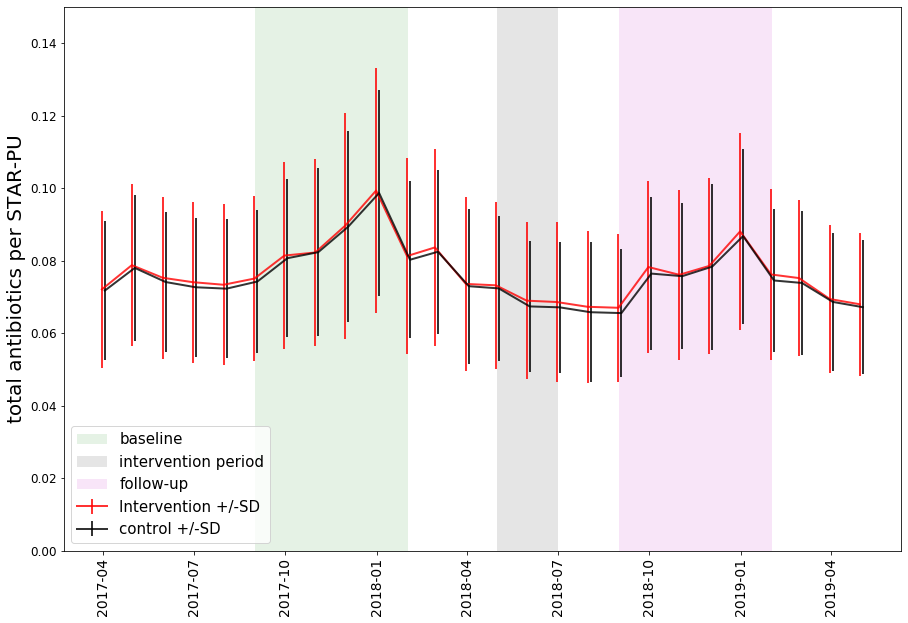

In [87]:
import matplotlib.pyplot as plt

# merge MONTHLY data with practice allocations 
dfp = dftotal.loc[(dftotal.month_no>-14) & (dftotal.month_no<22)]
# remove rows where measure value is null, or denominator (practice population) very small
dfp = dfp.loc[~(pd.isnull(dfp.calc_value))&(dfp.denominator>100)]

plot_timetrends(df=dfp, ymin=0, ymax=0.15, ylabel="total antibiotics per STAR-PU")

In [88]:
### select data only for the baseline and follow-up periods
import datetime
dft2 = dftotal.copy()
conditions = [
    (dft2['month']  >= d4), # after follow-up period
    (dft2['month']  >= d3), # follow-up
    (dft2['month']  >= d2), # mid
    (dft2['month']  >= d1), # baseline
    (dft2['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dft2['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dft2 = dft2[["practice_id","period", "month", "numerator","denominator"]]
dft2 = dft2.set_index(["practice_id","period", "month"])
dft2.head(5)

numerator  denominator
practice_id period    month                             
A81001      mid       2018-04-01        236  2461.578376
            before    2017-03-01        192  2503.504525
            mid       2018-03-01        212  2460.195453
            baseline  2017-12-01        236  2474.807131
            follow-up 2018-10-01        235  2457.212625

In [89]:

dftm = dft2.reset_index()
dftm = dftm.loc[(dftm.period=="baseline") | (dftm.period=="follow-up")]

### sum numerator (items) and average the denominators (STAR-PUs) for each practice for each period
dftm = dftm.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"mean"})

### calculate aggregated measure values
dftm["calc_value"] = dftm.numerator / dftm.denominator

# unstack years
dftm = dftm.reset_index()
dftm = dftm[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dftm = dftm.unstack(1)

# rename columns appropriately
dftm.columns = dftm.columns.droplevel()
dftm.columns.values[0] = 'Baseline Measure'
dftm.columns.values[1] = 'Follow-up Measure'
dftm.columns.values[2] = 'Baseline Items'
dftm.columns.values[3] = 'Follow-up Items'
dftm.columns.values[4] = 'Baseline Denominator'
dftm.columns.values[5] = 'Follow-up Denominator'

dftm = prac.merge(dftm, how='left', on='practice_id')
dftm.head()

,practice_id,ccg_id,allocation,group_ab,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
0,A83060,00D,I,A,0.751210,0.608145,1326,1069,1765.153106,1757.804892
1,A83050,00J,I,A,0.693137,0.615836,4890,4431,7054.885821,7195.094479
2,A83637,00J,con,con,0.860310,0.861729,1004,1024,1167.021021,1188.308577
3,A81040,00K,con,con,0.662979,0.581477,3209,2811,4840.275634,4834.242004
4,A84007,00L,I,A,0.565140,0.506479,3569,3175,6315.252510,6268.768382


In [90]:
import statsmodels.formula.api as smf
data = dftm.copy()

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.780
Model:                                   OLS   Adj. R-squared:                  0.780
Method:                        Least Squares   F-statistic:                     2416.
Date:                       Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                               13:36:13   Log-Likelihood:                 1881.1
No. Observations:                       1366   AIC:                            -3756.
Df Residuals:                           1363   BIC:                            -3740.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0571      0.006      9.169      0.000       0.045       0.069
data["Baseline Measure"]     0.7945      0.011     69.477      0.000       0.772       0.817
intervention                 0.0035      0.003      1.071      0.284      -0.003       0.010
==============================================================================
Omnibus:                      393.679   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26003.876
Skew:                           0.402   Prob(JB):                         0.00
Kurtosis:                      24.360   Cond. No.                         9.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
summary = data.groupby("intervention")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

summary.round(3)

,Baseline Measure,Follow-up Measure,change
0,0.506,0.458,-0.048
1,0.509,0.464,-0.045
2,0.004,0.007,0.003


In [92]:
import statsmodels.formula.api as smf
data = dftm.loc[dftm.allocation=="I"].copy()

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.796
Model:                                   OLS   Adj. R-squared:                  0.795
Method:                        Least Squares   F-statistic:                     1332.
Date:                       Tue, 05 May 2020   Prob (F-statistic):          2.05e-236
Time:                               13:36:13   Log-Likelihood:                 922.63
No. Observations:                        686   AIC:                            -1839.
Df Residuals:                            683   BIC:                            -1826.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0593      0.008      7.025      0.000       0.043       0.076
data["Baseline Measure"]     0.7887      0.015     51.540      0.000       0.759       0.819
groupb                       0.0087      0.005      1.802      0.072      -0.001       0.018
==============================================================================
Omnibus:                      164.316   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6595.797
Skew:                          -0.080   Prob(JB):                         0.00
Kurtosis:                      18.190   Cond. No.                         8.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
summary = data.groupby("groupb")[["Baseline Measure", "Follow-up Measure"]].mean() 
'''summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)'''

summary.round(3)


,Baseline Measure,Follow-up Measure
groupb,,
0,0.505,0.458
1,0.513,0.471


### UTI antibiotics (ADQs)

In [94]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_uti_antibiotics
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dfuti = bq.cached_read(q, csv_path='data/uti_antibiotics_data.csv')
dfuti["month"] = pd.to_datetime(dfuti.month)
dfuti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287140 entries, 0 to 287139
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   numerator         287140 non-null  float64       
 1   denominator       287140 non-null  int64         
 2   practice_id       287140 non-null  object        
 3   pcn_id            236460 non-null  object        
 4   pct_id            287140 non-null  object        
 5   stp_id            285740 non-null  object        
 6   regional_team_id  285740 non-null  object        
 7   month             287140 non-null  datetime64[ns]
 8   calc_value        249335 non-null  float64       
 9   percentile        249335 non-null  float64       
 10  month_no          287140 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 24.1+ MB


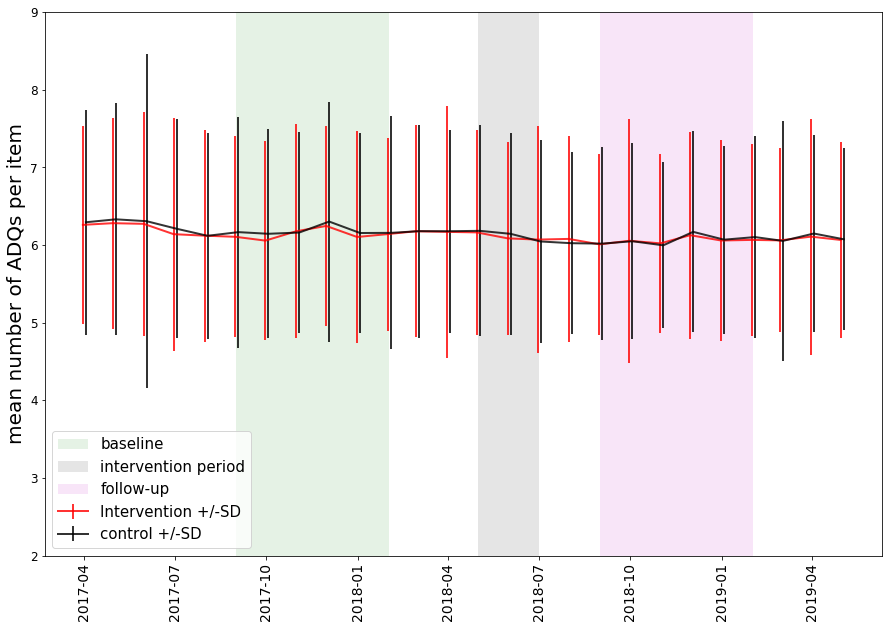

In [95]:
import matplotlib.pyplot as plt


# merge MONTHLY data with practice allocations 
dfuti2 = dfuti.loc[(dfuti.month_no>-14) & (dfuti.month_no<22)]


plot_timetrends(df=dfuti2,ymin=2,ymax=9,legend_loc="lower left",ylabel="mean number of ADQs per item")

**Statistical test**

In [96]:
### select data only for the baseline and follow-up periods
import datetime
dfutim = dfuti.copy()
conditions = [
    (dfutim['month']  >= d4), # after follow-up period
    (dfutim['month']  >= d3), # follow-up
    (dfutim['month']  >= d2), # mid
    (dfutim['month']  >= d1), # baseline
    (dfutim['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dfutim['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dfutim = dfutim[["practice_id","period", "month", "numerator","denominator"]]
dfutim = dfutim.set_index(["practice_id","period", "month"])

dfutim = dfutim.reset_index()
dfutim = dfutim.loc[(dfutim.period=="baseline") | (dfutim.period=="follow-up")]

### sum numerator (ADQs) and SUM the denominators (items) for each practice for each period
dfutim = dfutim.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"sum"})

### calculate aggregated measure values
dfutim["calc_value"] = dfutim.numerator / dfutim.denominator

# unstack years
dfutim = dfutim.reset_index()
dfutim = dfutim[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dfutim = dfutim.unstack(1)

# rename columns appropriately
dfutim.columns = dfutim.columns.droplevel()
dfutim.columns.values[0] = 'Baseline Measure'
dfutim.columns.values[1] = 'Follow-up Measure'
dfutim.columns.values[2] = 'Baseline Items'
dfutim.columns.values[3] = 'Follow-up Items'
dfutim.columns.values[4] = 'Baseline Denominator'
dfutim.columns.values[5] = 'Follow-up Denominator'

dfutim = prac.merge(dfutim, how='left', on='practice_id')


import statsmodels.formula.api as smf
data = dfutim.copy()
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.498
Model:                                   OLS   Adj. R-squared:                  0.497
Method:                        Least Squares   F-statistic:                     680.6
Date:                       Tue, 05 May 2020   Prob (F-statistic):          4.26e-206
Time:                               13:36:16   Log-Likelihood:                -1425.6
No. Observations:                       1376   AIC:                             2857.
Df Residuals:                           1373   BIC:                             2873.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.8851      0.116     16.255      0.000       1.658       2.113
data["Baseline Measure"]     0.6784      0.018     36.893      0.000       0.642       0.714
intervention                 0.0003      0.037      0.007      0.994      -0.072       0.072
==============================================================================
Omnibus:                      121.688   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              707.753
Skew:                           0.129   Prob(JB):                    2.06e-154
Kurtosis:                       6.504   Cond. No.                         40.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
summary = data.groupby("intervention")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

summary.round(2)

,Baseline Measure,Follow-up Measure,change
0,6.17,6.05,-0.11
1,6.12,6.04,-0.08
2,-0.04,-0.01,0.03


In [98]:
import statsmodels.formula.api as smf
data = dfutim.loc[dfutim.allocation=="I"].copy()

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.487
Model:                                   OLS   Adj. R-squared:                  0.486
Method:                        Least Squares   F-statistic:                     327.0
Date:                       Tue, 05 May 2020   Prob (F-statistic):          1.51e-100
Time:                               13:36:16   Log-Likelihood:                -747.36
No. Observations:                        691   AIC:                             1501.
Df Residuals:                            688   BIC:                             1514.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.7510      0.171     10.236      0.000       1.415       2.087
data["Baseline Measure"]     0.6936      0.027     25.546      0.000       0.640       0.747
groupb                       0.0839      0.054      1.542      0.124      -0.023       0.191
==============================================================================
Omnibus:                       72.808   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.458
Skew:                          -0.008   Prob(JB):                    2.36e-111
Kurtosis:                       7.206   Cond. No.                         40.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
summary = data.groupby("groupb")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

summary.round(2)

,Baseline Measure,Follow-up Measure,change
0,6.14,6.01,-0.13
1,6.11,6.08,-0.03
2,-0.03,0.06,0.10


### Trimethoprim

In [100]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_trimethoprim
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dftrim = bq.cached_read(q, csv_path='data/antibiotics_nitrofurantoin_data.csv')
dftrim["month"] = pd.to_datetime(dftrim.month)
dftrim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287140 entries, 0 to 287139
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   numerator         287140 non-null  int64         
 1   denominator       287140 non-null  int64         
 2   practice_id       287140 non-null  object        
 3   pcn_id            236460 non-null  object        
 4   pct_id            287140 non-null  object        
 5   stp_id            285740 non-null  object        
 6   regional_team_id  285740 non-null  object        
 7   month             287140 non-null  datetime64[ns]
 8   calc_value        249656 non-null  float64       
 9   percentile        249656 non-null  float64       
 10  month_no          287140 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 24.1+ MB


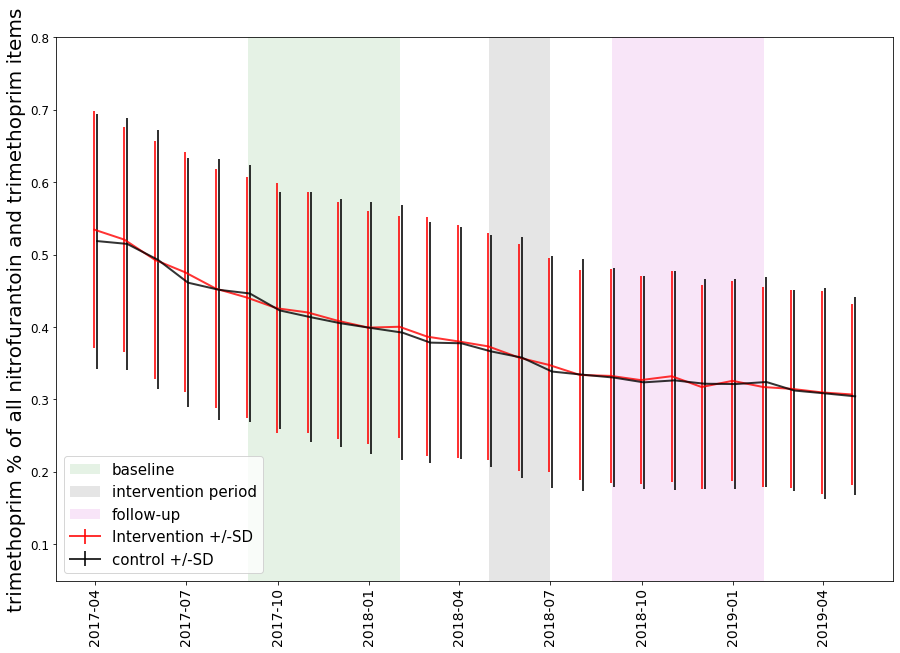

In [101]:
import matplotlib.pyplot as plt

# merge MONTHLY data with practice allocations 
trim = dftrim.loc[(dftrim.month_no>-14) & (dftrim.month_no<22)]
plot_timetrends(df=trim,ymax=0.8,
                ylabel="trimethoprim % of all nitrofurantoin and trimethoprim items")

In [102]:
### select data only for the baseline and follow-up periods
import datetime
dftrimm = dftrim.copy()
conditions = [
    (dftrimm['month']  >= d4), # after follow-up period
    (dftrimm['month']  >= d3), # follow-up
    (dftrimm['month']  >= d2), # mid
    (dftrimm['month']  >= d1), # baseline
    (dftrimm['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dftrimm['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dftrimm = dftrimm[["practice_id","period", "month", "numerator","denominator"]]
dftrimm = dftrimm.set_index(["practice_id","period", "month"])

dftrimm = dftrimm.reset_index()
dftrimm = dftrimm.loc[(dftrimm.period=="baseline") | (dftrimm.period=="follow-up")]

### sum numerator (items) and SUM the denominators (items) for each practice for each period
dftrimm = dftrimm.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"sum"})

### calculate aggregated measure values
dftrimm["calc_value"] = dftrimm.numerator / dftrimm.denominator

# unstack years
dftrimm = dftrimm.reset_index()
dftrimm = dftrimm[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dftrimm = dftrimm.unstack(1)

# rename columns appropriately
dftrimm.columns = dftrimm.columns.droplevel()
dftrimm.columns.values[0] = 'Baseline Measure'
dftrimm.columns.values[1] = 'Follow-up Measure'
dftrimm.columns.values[2] = 'Baseline Items'
dftrimm.columns.values[3] = 'Follow-up Items'
dftrimm.columns.values[4] = 'Baseline Denominator'
dftrimm.columns.values[5] = 'Follow-up Denominator'

dftrimm = prac.merge(dftrimm, how='left', on='practice_id')


import statsmodels.formula.api as smf
data = dftrimm.copy()
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.493
Model:                                   OLS   Adj. R-squared:                  0.492
Method:                        Least Squares   F-statistic:                     667.0
Date:                       Tue, 05 May 2020   Prob (F-statistic):          3.76e-203
Time:                               13:36:18   Log-Likelihood:                 1365.5
No. Observations:                       1377   AIC:                            -2725.
Df Residuals:                           1374   BIC:                            -2709.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0715      0.008      9.252      0.000       0.056       0.087
data["Baseline Measure"]     0.6101      0.017     36.521      0.000       0.577       0.643
intervention                 0.0005      0.005      0.097      0.922      -0.009       0.010
==============================================================================
Omnibus:                      132.167   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.376
Skew:                           0.263   Prob(JB):                    3.03e-153
Kurtosis:                       6.459   Cond. No.                         9.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
summary = data.groupby("intervention")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(3)

,Baseline Measure,Follow-up Measure,change
0,41.4,32.4,-9.0
1,41.5,32.6,-8.9
2,0.1,0.2,0.0


In [104]:
import statsmodels.formula.api as smf
data = dftrimm.loc[dftrimm.allocation=="I"].copy()

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     data["Follow-up Measure"]   R-squared:                       0.441
Model:                                   OLS   Adj. R-squared:                  0.439
Method:                        Least Squares   F-statistic:                     271.3
Date:                       Tue, 05 May 2020   Prob (F-statistic):           1.28e-87
Time:                               13:36:18   Log-Likelihood:                 663.74
No. Observations:                        692   AIC:                            -1321.
Df Residuals:                            689   BIC:                            -1308.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0850      0.012      7.375      0.000       0.062       0.108
data["Baseline Measure"]     0.5840      0.025     23.290      0.000       0.535       0.633
groupb                      -0.0044      0.007     -0.622      0.534      -0.018       0.009
==============================================================================
Omnibus:                      103.359   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.647
Skew:                           0.457   Prob(JB):                    3.53e-149
Kurtosis:                       7.783   Cond. No.                         9.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
summary = data.groupby("groupb")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(3)

,Baseline Measure,Follow-up Measure,change
0,41.6,32.7,-8.8
1,41.5,32.5,-9.1
2,-0.0,-0.2,-0.2


## Subgroup analyses

### SA1. Regression for Intervention vs Control - analyse effect of LIST SIZE

In [ ]:
import statsmodels.formula.api as smf

data = dfx2.copy()
data['intervention'] = data.allocation.map({'con':0, 'I':1})

# find average list size of each practice, during the intervention period
q = '''SELECT practice, 
avg(total_list_size) AS list_size 
FROM ebmdatalab.hscic.practice_statistics
WHERE month BETWEEN "2018-05-01" AND "2018-07-01"
GROUP BY practice
'''
listsize = bq.cached_read(q, csv_path='data/list_size_covariate_data.csv')


data = data.merge(listsize, left_on="practice_id", right_on="practice", how="inner")

# convert list size to deciles
data["list_size_decile"] = 100*(data["list_size"].rank(pct=True)).round(1) 


lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + list_size_decile + intervention', data=data).fit()

lm.summary()

### SA2. Regression for subgroup of intervention group INTERACTING with any intervention

**Obtain data**

In [ ]:
campaign2 = pd.read_csv('data/pageviews_wave123.csv',usecols={"Page","Pageviews","Medium","Segment","Unique Pageviews","Avg. Time on Page","Bounce Rate"})

c = campaign2.copy()
c = c.loc[c['Page'].str.find('practice') !=-1]
# extract practice, wave and medium information:
n0 = c['Page'].str.find('practice')+len("practice/")
n1 = c['Medium'].str.find(' ')
c["n0"] = n0
n2 = c['Segment'].str.len()

# trim medium to reduce the options to 'post 'email' and 'fax'
c["medium"] = c.Medium.str[0:1]


c[['x','practice_id']] = c['Page'].str.split("practice/",expand=True)
c['practice_id'] = c['practice_id'].str[0:6]
#c["n0"]
c["wave"] = c["Segment"].str[-1].astype(int)

c = c[c['practice_id'] != ""].drop(["Medium","Segment","x","n0"], axis=1)

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head(10)

### NB some lines appear with no data due to the way the report is produced in Analytics

c = c.loc[c["Pageviews"]>0]
browsing = c.copy() # for exploratory analysis later

# group by practice and find max page views (will convert to boolian in next cell)
c = c.groupby(["practice_id"])["Pageviews"].max().reset_index()
c.head()

**Summary**

In [ ]:
data = dfx2.loc[dfx2.allocation=="I"]

####### find interacting vs not interacting ######################
data = data.merge(c, on="practice_id", how="left")
data['interaction'] = np.where(data["Pageviews"]>0, 1, 0)

summary = data.groupby("interaction").agg({"practice_id":"count","Baseline Measure":"mean", "Follow-up Measure":"mean"}) 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

summary.round(4)

**Analysis**

In [ ]:
##The primary prescribing outcome measure will also be compared between the sub-groups 
# interacting with the link supplied, versus those not interacting; 

import statsmodels.formula.api as smf

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + interaction', data=data).fit()

lm.summary()

### SA3. Regression for subgroup of intervention group OPTING OUT


In [ ]:

# ...and for the sub-group which excludes those opting-out of the intervention.

# Identify which practices were successfully contacted: 
# load csv containing information which means of contact were sent to each practice and which were undelivered
# NB all null for letters.

cont = pd.read_csv('data/intervention_report_v2.csv',usecols={"practice_id","wave","method","sent","delivery_success"}).fillna(0)
cont = cont.rename(columns={"method":"medium"})

c2 = cont.groupby(["practice_id","wave"])[["sent"]].sum().reset_index()
c2 = pd.pivot(c2, index="practice_id", columns="wave", values="sent").reset_index()
c2["flag"] = np.where(c2[3]<=1, 1, 0)
c2[c2["flag"]>0]


data = dfx2.loc[dfx2.allocation=="I"] # include intervention group only
data = data.merge(c2[["practice_id","flag"]], on="practice_id", how="left")


####### find opting out vs not opting out ######################
import statsmodels.formula.api as smf
data['opt_out'] = data["flag"]


lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + opt_out', data=data).fit()

lm.summary()